In [5]:
%matplotlib inline
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string
import math

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from nltk import word_tokenize

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import requests
import pandas as pd
import xml.etree.ElementTree as ET
import warnings
import math
from tqdm import tqdm
from irsx.xmlrunner import XMLRunner
xml_runner = XMLRunner()
warnings.filterwarnings('ignore')

### Remapping US nonprofits

In [10]:
df_index=pd.concat([pd.read_csv('https://s3.amazonaws.com/irs-form-990/index_'+str(year)+'.csv') for year in range(2015, 2021)], ignore_index=True)
df_index['tax_year_end']=[str(s)[0:4] for s in df_index.TAX_PERIOD]
df_index.groupby('tax_year_end').count()

,RETURN_ID,FILING_TYPE,EIN,TAX_PERIOD,SUB_DATE,TAXPAYER_NAME,RETURN_TYPE,DLN,OBJECT_ID
tax_year_end,,,,,,,,,
2012,428,428,428,428,428,428,428,428,428
2013,4014,4014,4014,4014,4014,4014,4014,4014,4014
2014,314450,314450,314450,314450,314450,314450,314450,314450,314450
2015,408841,408841,408841,408841,408841,408841,408841,408841,408841
2016,431843,431843,431843,431843,431843,431843,431843,431843,431843
2017,452454,452454,452454,452454,452454,452454,452454,452454,452454
2018,439161,439161,439161,439161,439161,439161,439161,439161,439161
2019,57108,57108,57108,57108,57108,57108,57108,57108,57108
2108,1,1,1,1,1,1,1,1,1


In [17]:
df_index_2018=df_index[df_index.tax_year_end=='2018']
df_index_2018.sample(5)

,RETURN_ID,FILING_TYPE,EIN,TAX_PERIOD,SUB_DATE,TAXPAYER_NAME,RETURN_TYPE,DLN,OBJECT_ID,tax_year_end
2011927,16993542,EFILE,814049787,201812,1/3/2020 12:56:23 PM,02 SCHOLARSHIP FUND INC,990EZ,93492317032699,201943179349203269,2018
1871946,16580380,EFILE,474675656,201812,8/19/2019 11:04:46 AM,NAPUUOMALEI,990PF,93491133039689,201931339349103968,2018
1640232,16785331,EFILE,481078400,201812,10/28/2019 6:16:28 AM,KANSAS ACADEMY OF FAMILY PHYSICIANS INC,990O,93493248014019,201912489349301401,2018
2034274,17093729,EFILE,352069047,201812,1/31/2020 7:54:31 AM,FATHERS AND FAMILIES RESOURCERSEARCH CENTER INC,990,93493319133379,201923199349313337,2018
1893403,16573350,EFILE,820631249,201812,8/16/2019 8:33:52 AM,SOUTHERN ARTISAN TRAINING INSTITUTE INC,990EZ,93492130026819,201911309349202681,2018


#### Acquiring text data

In [18]:
import ipyparallel as ipp
c = ipp.Client()
print(c.ids)
dview = c[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


In [25]:
done_index_list=[]
dview.execute('import pandas as pd')
dview.execute('from time import sleep')
dview.execute('from irsx.xmlrunner import XMLRunner')
dview.execute('import os')
dview['xml_runner'] = XMLRunner()
dview['df_index'] = df_index
dview['df_index_text_acq'] = pd.DataFrame()
dview['done_index_list'] = list(set(done_index_list))
dview['counter']=0

In [27]:
@dview.parallel(block=True)
def func_text_acq(index):
    global df_index_2018, done_index_list, df_index_text_acq, counter
    
    ###### Define functions ######################################
    def func_irs990_text(obj_id):
        IRS990_result=xml_runner.run_sked(obj_id, 'IRS990').result

        ############## Check filing version.##############
        if IRS990_result!=None:
            IRS990_result=IRS990_result[0]
        else:
            return {'IRS990_p1_ActvtyOrMssnDsc': 'VERSION_NOT_SUPPORTED',
                    'IRS990_p3_MssnDsc': 'VERSION_NOT_SUPPORTED',
                    'IRS990_p3_DscS': 'VERSION_NOT_SUPPORTED',
                    'IRS990ScheduleO_ExplntnTxt': 'VERSION_NOT_SUPPORTED',
                   }
        ##################################################

        ###### IRS990_p1_ActvtyOrMssnDsc #################
        IRS990_p1_ActvtyOrMssnDsc=IRS990_result['schedule_parts']['part_i']['ActvtyOrMssnDsc']
        ##################################################

        ##### IRS990_p3_MssnDsc, IRS990_p3_DscS ##########
        IRS990_p3=IRS990_result['schedule_parts']['part_iii']
        IRS990_p3_MssnDsc='##'.join([IRS990_p3[key] for key in IRS990_p3.keys() if key=='MssnDsc'])
        IRS990_p3_DscS='##'.join([IRS990_p3[key] for key in IRS990_p3.keys() if (key=='Dsc' or '_Dsc' in key)])
        ##################################################

        ###### IRS990ScheduleO_ExplntnTxt #################
#         if 'InfInSkdOPrtIIIInd' in IRS990_p3.keys() and IRS990_p3['InfInSkdOPrtIIIInd']=='X' and 'IRS990ScheduleO' in xml_runner.run_filing(obj_id).list_schedules():
        if 'IRS990ScheduleO' in xml_runner.run_filing(obj_id).list_schedules():
            IRS990ScheduleO=xml_runner.run_sked(obj_id, 'IRS990ScheduleO').result[0]
            IRS990ScheduleO_ExplntnTxt='##'.join([s['ExplntnTxt'] for s in IRS990ScheduleO['groups']['SkdOSpplmntlInfrmtnDtl'] if 'III' in s['FrmAndLnRfrncDsc']])
        else:
            IRS990ScheduleO_ExplntnTxt=''
        ##################################################

        return {'IRS990_p1_ActvtyOrMssnDsc': IRS990_p1_ActvtyOrMssnDsc,
                'IRS990_p3_MssnDsc': IRS990_p3_MssnDsc,
                'IRS990_p3_DscS': IRS990_p3_DscS,
                'IRS990ScheduleO_ExplntnTxt': IRS990ScheduleO_ExplntnTxt,
               }
    
    def func_irs990ez_text(obj_id):
        IRS990EZ_result=xml_runner.run_sked(obj_id, 'IRS990EZ').result

        ############## Check filing version.##############
        if IRS990EZ_result!=None:
            IRS990EZ_result=IRS990EZ_result[0]
        else:
            return {'IRS990EZ_p3_PrmryExmptPrpsTxt': 'VERSION_NOT_SUPPORTED',
                    'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt': 'VERSION_NOT_SUPPORTED',
                    'IRS990ScheduleO_ExplntnTxt': 'VERSION_NOT_SUPPORTED',
                   }
        ########################################################

        ###### IRS990EZ_p3_PrmryExmptPrpsTxt #############
        if 'ez_part_iii' in IRS990EZ_result['schedule_parts'].keys():
            IRS990EZ_p3=IRS990EZ_result['schedule_parts']['ez_part_iii']
            IRS990EZ_p3_PrmryExmptPrpsTxt='##'.join([IRS990EZ_p3[key] for key in IRS990EZ_p3.keys() if key=='PrmryExmptPrpsTxt'])
        else:
            IRS990EZ_p3_PrmryExmptPrpsTxt=''
        ##################################################

        ####### IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt ######
        if 'EZPrgrmSrvcAccmplshmnt' in IRS990EZ_result['groups'].keys():
            IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt='##'.join([s['DscrptnPrgrmSrvcAccmTxt'] for s in IRS990EZ_result['groups']['EZPrgrmSrvcAccmplshmnt']])
        else:
            IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt=''
        ##################################################

        ###### IRS990ScheduleO_ExplntnTxt #################
#         if 'InfInSkdOPrtIIIInd' in IRS990EZ_p3.keys() and IRS990EZ_p3['InfInSkdOPrtIIIInd']=='X' and 'IRS990ScheduleO' in xml_runner.run_filing(obj_id).list_schedules():
        if 'IRS990ScheduleO' in xml_runner.run_filing(obj_id).list_schedules():
            IRS990ScheduleO=xml_runner.run_sked(obj_id, 'IRS990ScheduleO').result[0]
            IRS990ScheduleO_ExplntnTxt='##'.join([s['ExplntnTxt'] for s in IRS990ScheduleO['groups']['SkdOSpplmntlInfrmtnDtl'] if 'III' in s['FrmAndLnRfrncDsc']])
        else:
            IRS990ScheduleO_ExplntnTxt=''
        ##################################################

        return {'IRS990EZ_p3_PrmryExmptPrpsTxt': IRS990EZ_p3_PrmryExmptPrpsTxt,
                'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt': IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt,
                'IRS990ScheduleO_ExplntnTxt': IRS990ScheduleO_ExplntnTxt,
               }

    def func_irs990pf_text(obj_id):
        IRS990PF_result=xml_runner.run_sked(obj_id, 'IRS990PF').result

        ############## Check filing version.##############
        if IRS990PF_result!=None:
            IRS990PF_result=IRS990PF_result[0]
        else:
            return {'IRS990PF_p9a_DscrptnTxt': 'VERSION_NOT_SUPPORTED',
                    'IRS990PF_p16b_RltnshpSttmntTxt': 'VERSION_NOT_SUPPORTED',
                   }
        ########################################################

        ##### IRS990PF_p9a_DscrptnTxt ##########################
        if 'pf_part_ixa' in IRS990PF_result['schedule_parts'].keys():
            IRS990PF_p9a=IRS990PF_result['schedule_parts']['pf_part_ixa']
            IRS990PF_p9a_DscrptnTxt='##'.join([IRS990PF_p9a[key] for key in IRS990PF_p9a.keys() if 'Txt' in key])
        else:
            IRS990PF_p9a_DscrptnTxt=''
        ########################################################

        ##### IRS990PF_p16b_RltnshpSttmntTxt ###################
        if 'PFRlnOfActyTAccmOfExmptPrps' in IRS990PF_result['groups']:
            IRS990PF_p16b_RltnshpSttmntTxt='##'.join([s['RltnshpSttmntTxt'] for s in IRS990PF_result['groups']['PFRlnOfActyTAccmOfExmptPrps']])
        else:
            IRS990PF_p16b_RltnshpSttmntTxt=''
        ########################################################

        return {'IRS990PF_p9a_DscrptnTxt':IRS990PF_p9a_DscrptnTxt,
                'IRS990PF_p16b_RltnshpSttmntTxt':IRS990PF_p16b_RltnshpSttmntTxt,
               }
    ###### Define functions ######################################
    
    ###### Run main function ################################
    try:
        if index not in done_index_list:
            obj_id = df_index.loc[index, 'OBJECT_ID']
            return_type=df_index.loc[index, 'RETURN_TYPE']
            if return_type in ['990', '990O']:
                text_dict=func_irs990_text(obj_id)
                df_index.loc[index, 'IRS990_p1_ActvtyOrMssnDsc']=text_dict['IRS990_p1_ActvtyOrMssnDsc']
                df_index.loc[index, 'IRS990_p3_MssnDsc']=text_dict['IRS990_p3_MssnDsc']
                df_index.loc[index, 'IRS990_p3_DscS']=text_dict['IRS990_p3_DscS']
                df_index.loc[index, 'IRS990ScheduleO_ExplntnTxt']=text_dict['IRS990ScheduleO_ExplntnTxt']
            elif return_type in ['990EZ', '990EO']:
                text_dict=func_irs990ez_text(obj_id)
                df_index.loc[index, 'IRS990EZ_p3_PrmryExmptPrpsTxt']=text_dict['IRS990EZ_p3_PrmryExmptPrpsTxt']
                df_index.loc[index, 'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt']=text_dict['IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt']
                df_index.loc[index, 'IRS990ScheduleO_ExplntnTxt']=text_dict['IRS990ScheduleO_ExplntnTxt']
            elif return_type in ['990PF']:
                text_dict=func_irs990pf_text(obj_id)
                df_index.loc[index, 'IRS990PF_p9a_DscrptnTxt']=text_dict['IRS990PF_p9a_DscrptnTxt']
                df_index.loc[index, 'IRS990PF_p16b_RltnshpSttmntTxt']=text_dict['IRS990PF_p16b_RltnshpSttmntTxt']
            df_index_text_acq=pd.concat([df_index_text_acq, df_index.loc[[index]]], ignore_index=True)
            done_index_list+=[index]

            #### update progress file #####
            with open('../../output/pid_log/pid_'+str(os.getpid())+'.log', 'a') as log:
                log.write(str(index)+'\n')
            #### update progress file #####

    ###### Run main function ################################

            #### Sleep 2 seconds every 300 requests, adding ~2.5 hours in total #####
            counter+=1
            if counter%300==0:
                sleep(2)
            else:
                pass
            #### Sleep 2 seconds every 300 requests, adding ~2.5 hours in total #####
    except:
        pass

In [53]:
t=func_text_acq.map(df_index_2018.index)

In [54]:
done_index_list=list(dview.gather('done_index_list')) # Sync done_index_list.
len(set(done_index_list)), len(pd.concat(dview.gather('df_index_text_acq'), ignore_index=True))

(439160, 439160)

In [57]:
df_EIN_TXT_2018=pd.concat(dview.gather('df_index_text_acq'), ignore_index=True)
len(df_EIN_TXT_2018), len(df_index_2018)

(439160, 439161)

In [58]:
df_EIN_TXT_2018.to_pickle('../../dataset/intermediary/df_EIN_TXT_2018.pkl.bz2', compression='bz2')

#### Get BMF file and NTEE

In [6]:
# Read in data.
df_EIN_TXT_2018=pd.read_pickle('../../dataset/intermediary/df_EIN_TXT_2018.pkl.bz2', compression='bz2')
bmf_urls=['https://nccs-data.urban.org/data/bmf/2020/bmf.bm2004.csv',
          'https://nccs-data.urban.org/data/bmf/2019/bmf.bm1908.csv',
          'https://nccs-data.urban.org/data/bmf/2018/bmf.bm1812.csv'
         ]
df_bmf_18_20=pd.concat([pd.read_csv(url) for url in bmf_urls], ignore_index=True)

In [7]:
df_bmf_18_20_dropdup=df_bmf_18_20.loc[df_bmf_18_20.EIN.drop_duplicates().index]
df_bmf_18_20_dropdup.sample(5)

,EIN,SEC_NAME,FRCD,SUBSECCD,TAXPER,ASSETS,INCOME,NAME,ADDRESS,CITY,...,LEVEL1,NTMAJ10,MAJGRPB,LEVEL3,LEVEL2,NTMAJ12,NTMAJ5,FILER,ZFILER,NTEECONF
440774,272998238,NaN,20,7,201812.0,0.0,0.0,WATERWAY RADIO & CRUISING CLUB,27 CHEYENNE CT,PALM COAST,...,O,HU,N,HS,O,HU,HU,Y,Y,NaN
534440,331051626,NaN,20,3,201812.0,396398.0,25644.0,L C S C BUILDING ASSOCIATION,PO BOX 832,LEBANON,...,PC,PU,T,ZB,S,PU,OT,Y,N,NaN
803161,460452370,NaN,20,3,201812.0,0.0,0.0,COAL SPRINGS ANTIQUE CLUB,PO BOX 13,LANTRY,...,PC,HU,N,HS,O,HU,HU,Y,Y,NaN
146044,201780981,NaN,20,3,201906.0,0.0,0.0,LEXINGTON FAYETTE URBAN COUNTY GREENSPACE TRUS...,200 E MAIN ST,LEXINGTON,...,PC,PU,T,ZD,S,PU,OT,Y,Y,NaN
1276793,752340499,HILLCREST CEMETERY,20,13,201812.0,0.0,0.0,HILLCREST ASSOCIATION OF LUFKIN INC,221 S 2ND ST,LUFKIN,...,O,MU,Y,MO,M,MU,OT,Y,Y,NaN


In [8]:
# Merge text and BMF.
df_EIN_TXT_BMF_2018=df_EIN_TXT_2018.merge(df_bmf_18_20_dropdup, right_on='EIN', left_on='EIN', how='left')

In [9]:
df_EIN_TXT_BMF_2018.iloc[32]

RETURN_ID                                                                       15347325
FILING_TYPE                                                                        EFILE
EIN                                                                            814334694
TAX_PERIOD                                                                        201802
SUB_DATE                                                            5/26/2018 2:08:25 AM
TAXPAYER_NAME                                                    PROJECT HOPE MINISTRIES
RETURN_TYPE                                                                          990
DLN                                                                       93493099002038
OBJECT_ID                                                             201830999349300203
tax_year_end                                                                        2018
IRS990EZ_p3_PrmryExmptPrpsTxt                                                        NaN
IRS990EZ_p3_DscrptnPr

#### Create broad category

In [10]:
# Code as 10 broad categories.
broad_cat_dict={'I': ['A'],
                'II': ['B'],
                'III': ['C', 'D'],
                'IV': ['E', 'F', 'G', 'H'],
                'V': ['I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'],
                'VI': ['Q'],
                'VII': ['R', 'S', 'T', 'U', 'V', 'W'],
                'VIII': ['X'],
                'IX': ['Y'],
                'X': ['Z'],
               }
def ntee2cat(string):
    if str(string)!='nan':
        return [s for s in broad_cat_dict.keys() if string in broad_cat_dict[s]][0]
    else:
        return 'NULL'
df_EIN_TXT_BMF_2018['broad_cat']=df_EIN_TXT_BMF_2018.NTEE1.apply(ntee2cat)

In [11]:
df_EIN_TXT_BMF_2018.groupby('broad_cat').count()[['EIN']]

,EIN
broad_cat,
I,33233
II,58796
III,16708
IV,41458
IX,9114
NULL,6942
V,128976
VI,6644
VII,116865


#### Merge text fields

In [12]:
df_EIN_TXT_BMF_2018['mission']=df_EIN_TXT_BMF_2018['IRS990_p1_ActvtyOrMssnDsc'].combine_first(df_EIN_TXT_BMF_2018['IRS990_p3_MssnDsc']).combine_first(df_EIN_TXT_BMF_2018['IRS990EZ_p3_PrmryExmptPrpsTxt'])
df_EIN_TXT_BMF_2018['prgrm_dsc']=df_EIN_TXT_BMF_2018['IRS990_p3_DscS'].fillna('')+'##'+df_EIN_TXT_BMF_2018['IRS990ScheduleO_ExplntnTxt'].fillna('')+'##'+\
                                      df_EIN_TXT_BMF_2018['IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt'].fillna('')+'##'+df_EIN_TXT_BMF_2018['IRS990ScheduleO_ExplntnTxt'].fillna('')+'##'+\
                                      df_EIN_TXT_BMF_2018['IRS990PF_p9a_DscrptnTxt'].fillna('')+'##'+df_EIN_TXT_BMF_2018['IRS990PF_p16b_RltnshpSttmntTxt'].fillna('')

In [13]:
# Clean merged texts.
def func_clean_str(string):
    if str(string)=='nan':
        return ''
    else:
        string_set=set([s for s in string.split('##') if s!='']) # Remove duplicates.
        return '; '.join(string_set) # Join together.

df_EIN_TXT_BMF_2018['mission']=df_EIN_TXT_BMF_2018['mission'].map(func_clean_str)
df_EIN_TXT_BMF_2018['prgrm_dsc']=df_EIN_TXT_BMF_2018['prgrm_dsc'].map(func_clean_str)

In [14]:
df_EIN_TXT_BMF_2018.sample(3)

,RETURN_ID,FILING_TYPE,EIN,TAX_PERIOD,SUB_DATE,TAXPAYER_NAME,RETURN_TYPE,DLN,OBJECT_ID,tax_year_end,...,LEVEL3,LEVEL2,NTMAJ12,NTMAJ5,FILER,ZFILER,NTEECONF,broad_cat,mission,prgrm_dsc
321144,16802720,EFILE,541924406,201812,10/31/2019 8:29:28 AM,SADSAC,990,93493255007399,201942559349300739,2018,...,EN,O,EN,OT,Y,N,NaN,III,SAVE DOGS AND CATS BY PROVIDING EMERGENCY LIFE...,EMERGENCY VET SERVICESU
106524,16208664,EFILE,611418226,201809,4/5/2019 6:34:37 PM,ROBERT H TORSTENSON FAMILY FOUNDATION,990PF,93491036004009,201900369349100400,2018,...,ZC,S,PU,OT,Y,N,NaN,VII,,"TO PROVIDE FUNDING FOR SPECIFIC CHARITABLE, ED..."
70397,16285452,EFILE,526050847,201806,5/10/2019 6:28:25 AM,BIOPHYSICAL SOCIETY,990,93493081008329,201920819349300832,2018,...,HE,O,HE,HE,Y,N,NaN,IV,THE BIOPHYSICAL SOCIETY CONVENES AND CONNECTS ...,BIOPHYSICAL JOURNAL-THE JOURNAL IS A SEMIMONTH...


In [41]:
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck(doc):
    word_string_list=nltk.word_tokenize(doc)
    return ' '.join([SpellChecker().correction(word=s).upper() for s in word_string_list])

In [42]:
from dask.distributed import Client
import joblib
from joblib import Parallel, delayed
client = Client("10.140.82.220:8786")
client

Client Scheduler: tcp://10.140.82.220:8786 Dashboard: http://10.140.82.220:8787/status,Cluster Workers: 480 Cores: 480 Memory: 0 B


In [ ]:
# Sort by mission length, faster processing.
df_EIN_TXT_BMF_2018['mission_len']=[len(str(s)) for s in df_EIN_TXT_BMF_2018.mission]
df_EIN_TXT_BMF_2018.sort_values('mission_len', inplace=True)

# Correct mission.
with joblib.parallel_backend('dask'):
    %time df_EIN_TXT_BMF_2018['mission_spellchk']=Parallel(n_jobs=-1)(delayed(spellcheck)(doc=doc) for doc in df_EIN_TXT_BMF_2018['mission'])

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {'spellcheck-batch-0bd3c897994d49a0a7f68184546407fc': ('tcp://10.140.82.113:41373',)}
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {'spellcheck-batch-10edf1ac99ef4e30b39e6497240ddc9b': ('tcp://10.140.82.49:45337',)}


In [ ]:
# Sort by mission length, faster processing.
df_EIN_TXT_BMF_2018['prgrm_dsc_len']=[len(str(s)) for s in df_EIN_TXT_BMF_2018.prgrm_dsc]
df_EIN_TXT_BMF_2018.sort_values('prgrm_dsc_len', inplace=True)

# Correct mission.
with joblib.parallel_backend('dask'):
    %time df_EIN_TXT_BMF_2018['prgrm_dsc_spellchk']=Parallel(n_jobs=-1)(delayed(spellcheck)(doc=doc) for doc in df_EIN_TXT_BMF_2018['prgrm_dsc'])

In [96]:
# Correct mission.
df_EIN_TXT_BMF_2018['mission_spellchk']=p.map(spellcheck, df_EIN_TXT_BMF_2018['mission'])

In [ ]:
# Correct prgrm dsc.
df_EIN_TXT_BMF_2018['prgrm_dsc_spellchk']=p.map(spellcheck, df_EIN_TXT_BMF_2018['prgrm_dsc'])

### Viz function selection

In [46]:
df_grid_search_history_broad_cat=pd.read_csv('../../output/grid_search_history_broad_cat.tsv', sep='\t').sort_values('val_acc', ascending=False)

In [48]:
df_grid_search_history_broad_cat.sample(3)

,Unnamed: 0,acc,val_acc,val_acc_real,loss,val_loss,epochs,conv_num_filters,conv_kernel_size,conv_act,out_act,time_stamp
555,555,0.762768,0.734583,NaN,0.761871,0.842163,6,32,3,tanh,softmax,NaN
4936,4936,0.173631,0.170655,NaN,8.650764,8.679786,37,128,3,sigmoid,tanh,NaN
4133,4133,0.013601,0.014286,NaN,8.316889,8.213513,34,64,7,sigmoid,tanh,NaN


In [26]:
df_grid_search_history_broad_cat['conv_out_act']=df_grid_search_history_broad_cat.conv_act+'_'+df_grid_search_history_broad_cat.out_act

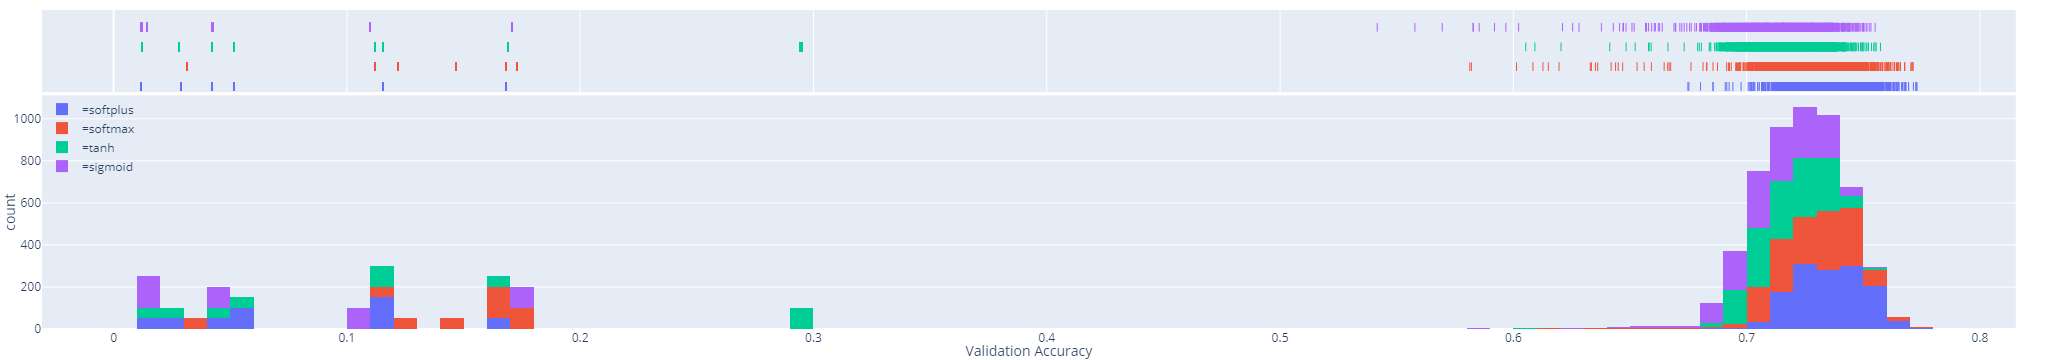

In [84]:
import plotly.express as px
fig = px.histogram(df_grid_search_history_broad_cat, x="val_acc", color="conv_act", marginal="rug", # can be `box`, `violin`
                         hover_data=df_grid_search_history_broad_cat.columns, nbins=150,
                   labels=dict(conv_act='', val_acc='Validation Accuracy', count='Count')
                  )
fig.update_layout(width=800, height=350)
fig.update_layout(
    legend=dict(x=0, y=0.6, orientation='v', bgcolor='rgba(0,0,0,0)'),
    margin={'t': 10, 'b': 10, 'r':0, 'l':20},
)
# fig.update_yaxes(title_text='Count')
fig.write_image('../../output/fig/grid_search_history_broad_cat.pdf')
fig.show()

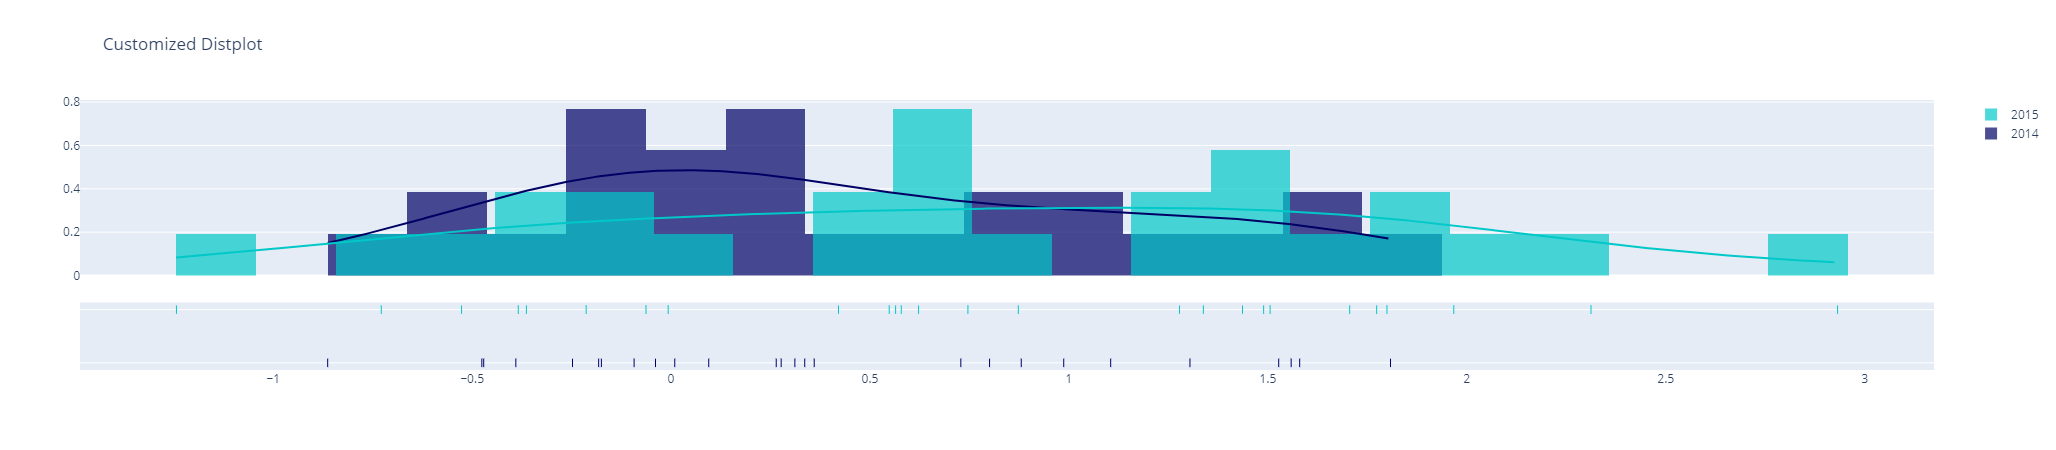

In [90]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(26)
x2 = np.random.randn(26) + .5

group_labels = ['2014', '2015']

rug_text_one = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                'u', 'v', 'w', 'x', 'y', 'z']

rug_text_two = ['aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj',
                'kk', 'll', 'mm', 'nn', 'oo', 'pp', 'qq', 'rr', 'ss', 'tt',
                'uu', 'vv', 'ww', 'xx', 'yy', 'zz']

rug_text = [rug_text_one, rug_text_two] # for hover in rug plot
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

# Create distplot with custom bin_size
fig = ff.create_distplot(
    [x1, x2], group_labels, bin_size=.2,
    rug_text=rug_text, colors=colors)

fig.update_layout(title_text='Customized Distplot')
fig.show()

### Missing data analysis

In [2]:
train_file_path='../../dataset/UCF/train/'
file_list=os.listdir(train_file_path)
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, pd.read_pickle(train_file_path+file, compression='gzip')])

test_file_path='../../dataset/UCF/test/'
file_list=os.listdir(test_file_path)
df_test=pd.DataFrame()
for file in file_list:
    df_test=pd.concat([df_test, pd.read_pickle(test_file_path+file, compression='gzip')])
    
len(df_train), len(df_test)

(154424, 38607)

In [26]:
df_train.columns

Index(['DLN', 'EIN', 'FILING_TYPE', 'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt',
       'IRS990EZ_p3_PrmryExmptPrpsTxt', 'IRS990PF_p16b_RltnshpSttmntTxt',
       'IRS990PF_p9a_DscrptnTxt', 'IRS990ScheduleO_ExplntnTxt',
       'IRS990_p1_ActvtyOrMssnDsc', 'IRS990_p3_DscS', 'IRS990_p3_MssnDsc',
       'OBJECT_ID', 'RETURN_ID', 'RETURN_TYPE', 'SUB_DATE', 'TAXPAYER_NAME',
       'TAX_PERIOD', 'YEAR', '95_and_before', 'NTEE1', 'mission', 'prgrm_dsc',
       'mission_spellchk', 'prgrm_dsc_spellchk'],
      dtype='object')

In [27]:
len(df_train[df_train.mission_spellchk.isna()]), len(df_train[df_train.mission_spellchk.isna()]), len(df_train[df_train.mission_spellchk=='']), len(df_train[df_train.mission_spellchk==''])

(0, 0, 0, 0)

In [28]:
len(df_test[df_test.mission_spellchk.isna()]), len(df_test[df_test.mission_spellchk.isna()]), len(df_test[df_test.mission_spellchk=='']), len(df_test[df_test.mission_spellchk==''])

(0, 0, 0, 0)

In [24]:
len(df_train[df_train.prgrm_dsc_spellchk.isna()]), len(df_train[df_train.prgrm_dsc_spellchk.isna()]), len(df_train[df_train.prgrm_dsc_spellchk=='']), len(df_train[df_train.prgrm_dsc_spellchk==''])

(0, 0, 0, 0)

In [25]:
len(df_test[df_test.prgrm_dsc_spellchk.isna()]), len(df_test[df_test.prgrm_dsc_spellchk.isna()]), len(df_test[df_test.prgrm_dsc_spellchk=='']), len(df_test[df_test.prgrm_dsc_spellchk==''])

(0, 0, 0, 0)

In [ ]:
# Export to Excel. 
df_train.to_excel('../../output/df_train.xlsx')
df_test.to_excel('../../output/df_test.xlsx')